In [1]:
from __future__ import annotations

import nltk
import pandas as pd
import plotly.express as px
import torch
from nltk import WordNetLemmatizer, word_tokenize
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/victorbarbarich/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Представление и предобработка текстовых данных в виде последовательностей

1.1 Представьте первое предложение из строки `text` как последовательность из индексов слов, входящих в это предложение

In [2]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

In [3]:
def split_text(_text: str) -> list[str]:
    """
    Разбивает текст на слова

    :param _text: строка с текстом;
    :return: список из слов в нижнем регистре
    """
    wnl = nltk.WordNetLemmatizer()
    _text = _text.lower()
    _text = nltk.word_tokenize(_text)
    _text = list(map(wnl.lemmatize, _text))
    return _text


print(split_text(text))

['select', 'your', 'preference', 'and', 'run', 'the', 'install', 'command', '.', 'stable', 'represents', 'the', 'most', 'currently', 'tested', 'and', 'supported', 'version', 'of', 'pytorch', '.', 'note', 'that', 'libtorch', 'is', 'only', 'available', 'for', 'c++']


In [4]:
idx_to_word = {u: v for u, v in enumerate(set(split_text(text)))}
word_to_idx = {v: u for u, v in idx_to_word.items()}

token_sentence = list(map(lambda x: word_to_idx[x], split_text(text)))
print(token_sentence)

[6, 17, 19, 24, 25, 22, 13, 10, 18, 11, 0, 22, 5, 15, 1, 24, 7, 9, 12, 16, 18, 2, 23, 20, 4, 3, 8, 21, 14]


1.2 Представьте первое предложение из строки `text` как последовательность векторов, соответствующих индексам слов. Для представления индекса в виде вектора используйте унитарное кодирование. В результате должен получиться двумерный тензор размера `количество слов в предложении` x `количество уникальных слов`

In [8]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

token_sentence = list(map(lambda x: word_to_idx[x], split_text(text)))
n = len(set(token_sentence))

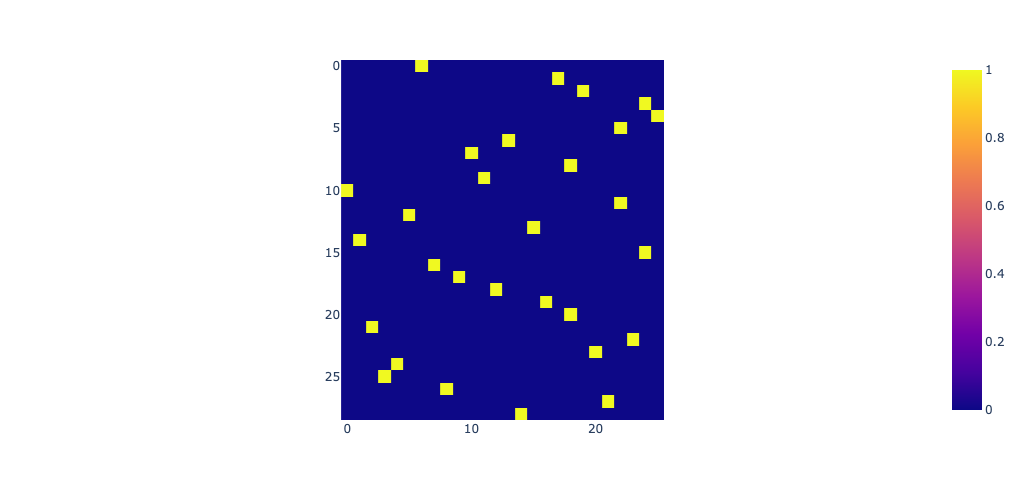

In [9]:
embedded_sentence = torch.zeros(len(token_sentence), n)

for i, j in enumerate(token_sentence):
    embedded_sentence[i, j] += 1

px.imshow(embedded_sentence).show(renderer='png', width=1024)

1.3 Решите задачу 1.2, используя модуль `nn.Embedding`

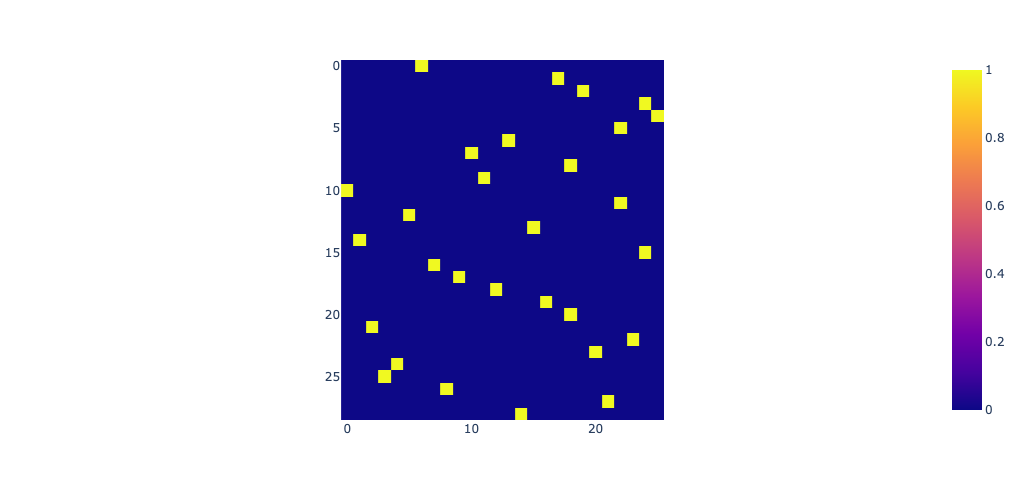

In [24]:
emb_layer = torch.nn.Embedding(num_embeddings=n, embedding_dim=n)  # Делаем эмбеддинг, он из случайных чисел

embedded_sentence_torch = emb_layer(torch.LongTensor(token_sentence)) * 0  # Делаем все нулями
embedded_sentence_torch[range(len(token_sentence)), token_sentence] += 1  # В нужные места добавляем 1

embedded_sentence_torch = embedded_sentence_torch.long()

px.imshow(embedded_sentence_torch).show(renderer='png', width=1024)

## 2. Классификация фамилий по национальности (ConvNet)

Датасет: https://disk.yandex.ru/d/owHew8hzPc7X9Q?w=1

2.1 Считать файл `surnames/surnames.csv`. 

2.2 Закодировать национальности числами, начиная с 0.

2.3 Разбить датасет на обучающую и тестовую выборку

2.4 Реализовать класс `Vocab` (токен = __символ__)
  * добавьте в словарь специальный токен `<PAD>` с индексом 0
  * при создании словаря сохраните длину самой длинной последовательности из набора данных в виде атрибута `max_seq_len`

2.5 Реализовать класс `SurnamesDataset`
  * метод `__getitem__` возвращает пару: <последовательность индексов токенов (см. 1.1 ), номер класса> 
  * длина каждой такой последовательности должна быть одинаковой и равной `vocab.max_seq_len`. Чтобы добиться этого, дополните последовательность справа индексом токена `<PAD>` до нужной длины

2.6. Обучить классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding`. Рассмотрите два варианта: 
    - когда токен представляется в виде унитарного вектора и модуль `nn.Embedding` не обучается
    - когда токен представляется в виде вектора небольшой размерности (меньше, чем размер словаря) и модуль `nn.Embedding` обучается

  * Используйте одномерные свертки и пулинг (`nn.Conv1d`, `nn.MaxPool1d`)
    - обратите внимание, что `nn.Conv1d` ожидает на вход трехмерный тензор размерности `(batch, embedding_dim, seq_len)`

2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

In [12]:
# 1
surnames = pd.read_csv('data/surnames.csv')
surnames.head(2)

,surname,nationality
0,Woodford,English
1,Coté,French


In [13]:
# 2
nationalities = surnames.nationality.unique()
nationality_to_idx = dict(zip(nationalities, range(len(nationalities))))
idx_to_nationalities = {v: u for u, v in nationality_to_idx.items()}

In [14]:
# 3
surnames_train, surnames_test = train_test_split(surnames, test_size=0.2)

In [232]:
# 4
class Vocab:
    """
    Этот класс будет хранить все возможные буквы (символы) из фамилий
    """

    def __init__(self, data: pd.DataFrame):
        data = data[['surname']].drop_duplicates()  # оставляем уникальные фамилии

        letters = data.surname.str.lower().str.split('').apply(lambda x: x[1:-1])  # разбиваем фамилии по буквам
        letters = set(letters.sum())  # находим все буквы

        self.idx_to_token = dict(zip(range(1, len(letters) + 1), letters))  # id - буква
        self.idx_to_token[0] = ''

        self.token_to_idx = dict(zip(letters, range(1, len(letters) + 1)))  # буква - id
        self.token_to_idx['<PAD>'] = 0

        self.vocab_len = len(self.idx_to_token)
        self.max_seq_len = data.surname.str.len().max()


vocab = Vocab(surnames)
vocab.vocab_len, vocab.token_to_idx['z'], vocab.idx_to_token[1]

(56, 16, 'k')

In [233]:
# 5
class SurnamesDataset(Dataset):
    def __init__(self, x, y, _vocab: Vocab):
        self.x = x
        self.y = y
        self.vocab = _vocab

    def vectorize(self, _surname: str):
        """ Генерирует представление фамилии surname в при помощи бинарного кодирования (см. 1.2) """
        output_vector = [0 for _ in range(vocab.max_seq_len)]
        _surname = _surname.lower()
        for l in range(len(_surname)):
            output_vector[vocab.max_seq_len - len(_surname) + l] = self.vocab.token_to_idx[_surname[l]]

        return torch.FloatTensor(output_vector)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.vectorize(self.x.iloc[idx]).long(), torch.tensor(nationality_to_idx[self.y.iloc[idx]])


In [234]:
dataset_testing = SurnamesDataset(surnames.surname, surnames.nationality, Vocab(surnames))

print(dataset_testing.vectorize('Woodford')[-10:])

print(len(dataset_testing), dataset_testing.vocab.vocab_len)
print(dataset_testing[1][0], dataset_testing[1][1], dataset_testing.x.iloc[1])

tensor([ 0.,  0., 48., 54., 54., 15.,  8., 54., 41., 15.])
10980 56
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2, 54, 33,  3]) tensor(1) Coté


In [235]:
vocab_train_dataset = SurnamesDataset(surnames_train.surname, surnames_train.nationality, Vocab(surnames))
vocab_test_dataset = SurnamesDataset(surnames_test.surname, surnames_test.nationality, Vocab(surnames))

kernels = [vocab.max_seq_len, 32, 32, 64, 64]
convs = torch.nn.Sequential()
for i in range(len(kernels) - 1):
    convs.add_module(f'conv {i}', torch.nn.Conv1d(kernels[i], kernels[i + 1], 3))
    convs.add_module(f'pooling {i}', torch.nn.MaxPool1d(2))
    convs.add_module(f'func {i}', torch.nn.LeakyReLU(0.1))

model = torch.nn.Sequential(
    torch.nn.Embedding(vocab.vocab_len, 128),
    convs,
    torch.nn.Dropout(0.5),
    torch.nn.Flatten(),
    torch.nn.Linear(384, 512),
    torch.nn.Dropout(0.5),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(512, len(nationality_to_idx))
)

model(next(iter(DataLoader(vocab_train_dataset)))[0]).shape

torch.Size([1, 18])

### Модель с кодовым названием dumb

In [243]:
kernels = [vocab.max_seq_len, 32, 32, 64, 64]
convs = torch.nn.Sequential()
for i in range(len(kernels) - 1):
    convs.add_module(f'conv {i}', torch.nn.Conv1d(kernels[i], kernels[i + 1], 3))
    convs.add_module(f'pooling {i}', torch.nn.MaxPool1d(2))
    convs.add_module(f'func {i}', torch.nn.LeakyReLU(0.1))

dumb_model = torch.nn.Sequential(
    torch.nn.Embedding(vocab.vocab_len, vocab.vocab_len),
    convs,
    torch.nn.Dropout(0.5),
    torch.nn.Flatten(),
    torch.nn.Linear(64, 512),
    torch.nn.Dropout(0.5),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(512, len(nationality_to_idx))
)


# torch.nn.init.eye_(list(dumb_model[0].parameters())[0].data)
list(dumb_model[0].parameters())[0].data = torch.eye(vocab.vocab_len, vocab.vocab_len)
list(dumb_model[0].parameters())[0].requires_grad = False


dumb_model(next(iter(DataLoader(vocab_train_dataset, batch_size=5)))[0]).shape

torch.Size([5, 18])

In [244]:
list(dumb_model[0].parameters())[0].data

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [245]:
optimizer = torch.optim.Adam(dumb_model.parameters(), weight_decay=0.001)
loss = torch.nn.CrossEntropyLoss()
loss_log = []
loss_log_val = []
min_val_loss = 10 ** 10

for i in range(10):
    epoch_loss = 0
    epoch_loss_val = 0

    j, k = 1, 1  # Делители running losses

    dumb_model.train()
    for j, (batch_x, batch_y) in enumerate(DataLoader(vocab_train_dataset, batch_size=64, shuffle=True), 1):
        y_pred = dumb_model(batch_x)
        running_loss = loss(y_pred, batch_y)
        epoch_loss += running_loss.item()

        running_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    dumb_model.eval()
    for k, (batch_x, batch_y) in enumerate(DataLoader(vocab_test_dataset, batch_size=64), 1):
        y_pred = dumb_model(batch_x)
        running_loss = loss(y_pred, batch_y)
        epoch_loss_val += running_loss.item()

    epoch_loss /= j
    epoch_loss_val /= k

    if epoch_loss_val < min_val_loss:
        torch.save(dumb_model.state_dict(), 'models/surname_dumb_model.pt')

    if i % 2 == 0:
        print(f'EPOCH: {i + 1:3d} \t LOSS: {epoch_loss:0.4f} \t VAL LOSS: {epoch_loss_val:0.4f}')

    loss_log.append(epoch_loss)
    loss_log_val.append(epoch_loss_val)

dumb_model.load_state_dict(torch.load('models/surname_dumb_model.pt'))

EPOCH:   1 	 LOSS: 2.2939 	 VAL LOSS: 2.2281
EPOCH:   3 	 LOSS: 2.1096 	 VAL LOSS: 2.0465
EPOCH:   5 	 LOSS: 1.8054 	 VAL LOSS: 1.7052
EPOCH:   7 	 LOSS: 1.5651 	 VAL LOSS: 1.4877
EPOCH:   9 	 LOSS: 1.4009 	 VAL LOSS: 1.3460


<All keys matched successfully>

In [246]:
list(dumb_model[0].parameters())[0].data

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

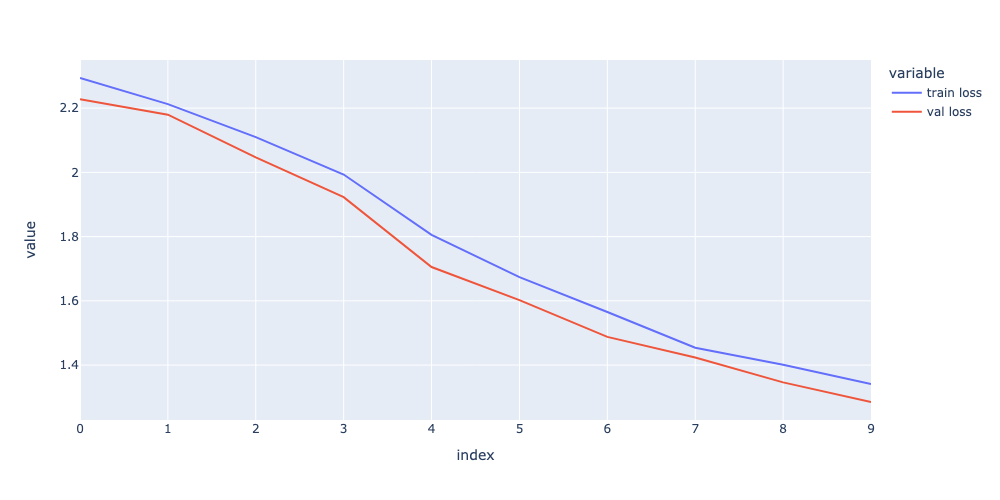

In [247]:
px.line(pd.DataFrame({'train loss': loss_log, 'val loss': loss_log_val})).show(renderer='png', width=1000)

In [248]:
dumb_model.eval()
right_answers = 0
answers = []
for batch_x, batch_y in DataLoader(vocab_train_dataset, batch_size=32):
    predictions = dumb_model(batch_x).argmax(dim=1)
    answers.extend(map(lambda x: idx_to_nationalities[int(x)], predictions))
    right_answers += (torch.eq(batch_y, predictions)).sum()

print(f'TRAIN ACCURACY: {right_answers / len(vocab_train_dataset):0.4f}')

TRAIN ACCURACY: 0.6584


In [249]:
right_answers = 0
answers = []
for batch_x, batch_y in DataLoader(vocab_test_dataset, batch_size=32):
    predictions = dumb_model(batch_x).argmax(dim=1)
    answers.extend(map(lambda x: idx_to_nationalities[int(x)], predictions))
    right_answers += (torch.eq(batch_y, predictions)).sum()

print(f'TEST ACCURACY: {right_answers / len(vocab_test_dataset):0.4f}')

TEST ACCURACY: 0.6416


In [250]:
nationalities_tests = [idx_to_nationalities[int(dataset_testing[i][1])] for i in range(len(dataset_testing))]

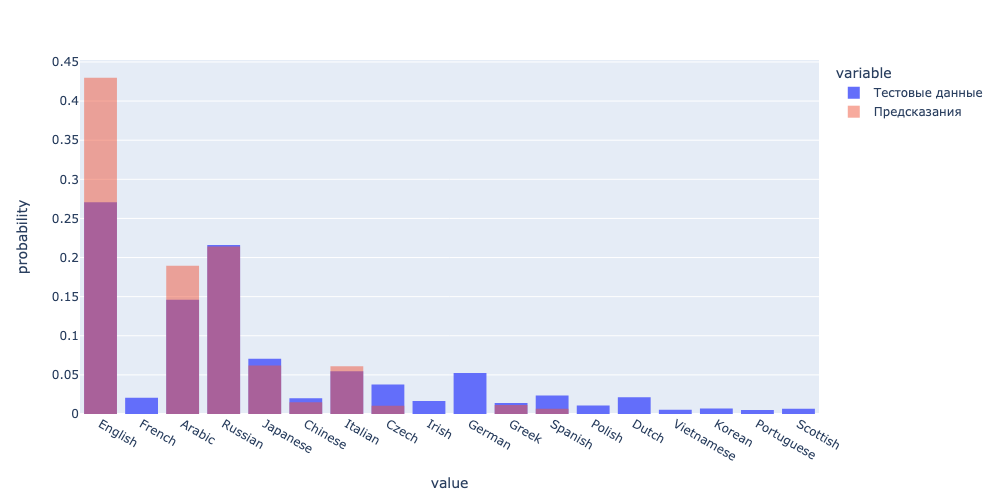

In [251]:
fig = px.histogram(pd.Series(nationalities_tests, name='Тестовые данные'), histnorm='probability')
fig.add_histogram(x=answers, histnorm='probability', opacity=0.5, name='Предсказания')
fig.update_layout(barmode='overlay')
fig.show(renderer='png', width=1000)

### Основная модель

In [199]:
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.001)
loss = torch.nn.CrossEntropyLoss()
loss_log = []
loss_log_val = []
min_val_loss = 10 ** 10

for i in range(10):
    epoch_loss = 0
    epoch_loss_val = 0

    j, k = 1, 1  # Делители running losses

    model.train()
    for j, (batch_x, batch_y) in enumerate(DataLoader(vocab_train_dataset, batch_size=64, shuffle=True), 1):
        y_pred = model(batch_x)
        running_loss = loss(y_pred, batch_y)
        epoch_loss += running_loss.item()

        running_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    for k, (batch_x, batch_y) in enumerate(DataLoader(vocab_test_dataset, batch_size=64), 1):
        y_pred = model(batch_x)
        running_loss = loss(y_pred, batch_y)
        epoch_loss_val += running_loss.item()

    epoch_loss /= j
    epoch_loss_val /= k

    if epoch_loss_val < min_val_loss:
        torch.save(model.state_dict(), 'models/surname_model.pt')

    if i % 2 == 0:
        print(f'EPOCH: {i + 1:3d} \t LOSS: {epoch_loss:0.4f} \t VAL LOSS: {epoch_loss_val:0.4f}')

    loss_log.append(epoch_loss)
    loss_log_val.append(epoch_loss_val)

model.load_state_dict(torch.load('models/surname_model.pt'))

EPOCH:   1 	 LOSS: 2.2178 	 VAL LOSS: 2.0674
EPOCH:   3 	 LOSS: 1.4679 	 VAL LOSS: 1.3369
EPOCH:   5 	 LOSS: 1.1706 	 VAL LOSS: 1.1302
EPOCH:   7 	 LOSS: 1.0363 	 VAL LOSS: 1.0679
EPOCH:   9 	 LOSS: 0.9603 	 VAL LOSS: 1.0048


<All keys matched successfully>

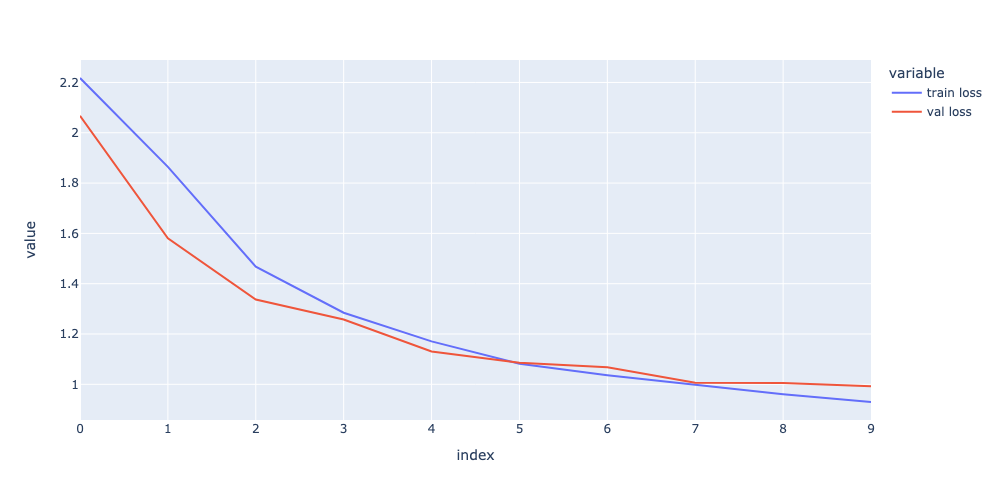

In [200]:
px.line(pd.DataFrame({'train loss': loss_log, 'val loss': loss_log_val})).show(renderer='png', width=1000)

In [201]:
model.eval()
right_answers = 0
answers = []
for batch_x, batch_y in DataLoader(vocab_train_dataset, batch_size=32):
    predictions = model(batch_x).argmax(dim=1)
    answers.extend(map(lambda x: idx_to_nationalities[int(x)], predictions))
    right_answers += (torch.eq(batch_y, predictions)).sum()

print(f'TRAIN ACCURACY: {right_answers / len(vocab_train_dataset):0.4f}')

TRAIN ACCURACY: 0.7508


In [202]:
right_answers = 0
answers = []
for batch_x, batch_y in DataLoader(vocab_test_dataset, batch_size=32):
    predictions = model(batch_x).argmax(dim=1)
    answers.extend(map(lambda x: idx_to_nationalities[int(x)], predictions))
    right_answers += (torch.eq(batch_y, predictions)).sum()

print(f'TEST ACCURACY: {right_answers / len(vocab_test_dataset):0.4f}')

TEST ACCURACY: 0.7113


In [203]:
nationalities_tests = [idx_to_nationalities[int(dataset_testing[i][1])] for i in range(len(dataset_testing))]

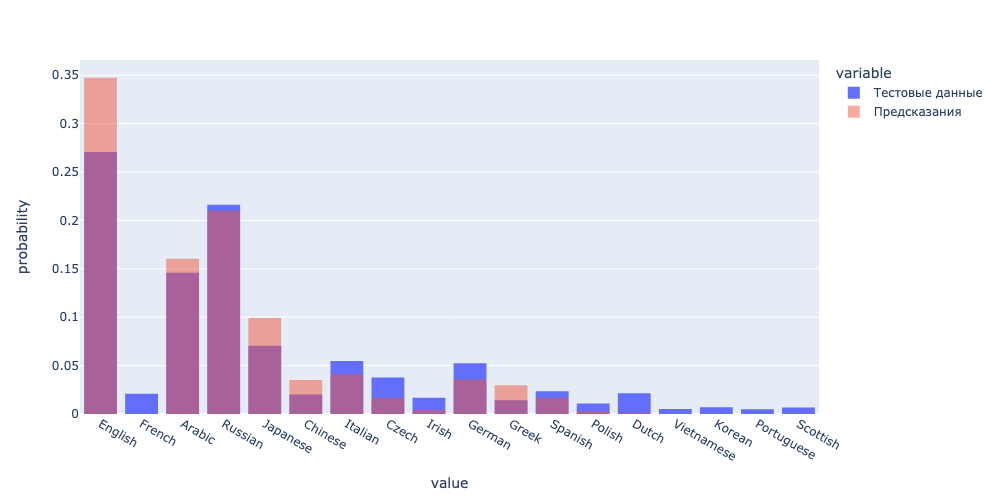

In [204]:
fig = px.histogram(pd.Series(nationalities_tests, name='Тестовые данные'), histnorm='probability')
fig.add_histogram(x=answers, histnorm='probability', opacity=0.5, name='Предсказания')
fig.update_layout(barmode='overlay')
fig.show(renderer='png', width=1000)

In [205]:
def tokenize_surname(_surname: str) -> torch.LongTensor:
    """
    Токенизирует фамилию

    :param _surname: фамилия строкой
    :return:
    """
    dataset = SurnamesDataset(None, None, vocab)
    return dataset.vectorize(_surname).reshape(1, vocab.max_seq_len).long()

In [206]:
our_surnames = {
    'Barbarich': 'Russian',
    'Akhmad': 'Arabic',
    'Tsoi': 'Korean',
    'Arakelyan': 'Russian',
    'Plastinina': 'Russian',
    'Frolov': 'Russian',
    'Geraskina': 'Russian',
    'Phan': 'Vietnamese'
}

for surname, nationality in our_surnames.items():

    preds = model(tokenize_surname(surname)).topk(3).indices.flatten()
    model_nat = [idx_to_nationalities[int(pred)] for pred in preds]

    if nationality == model_nat[0]:
        flag = '+'
    elif nationality in model_nat:
        flag = '+-'
    else:
        flag = '-'

    print(f'{flag} {surname.capitalize():>10} \t REAL: {nationality:>10} \t MODEL: {model_nat}')


+  Barbarich 	 REAL:    Russian 	 MODEL: ['Russian', 'German', 'Czech']
-     Akhmad 	 REAL:     Arabic 	 MODEL: ['English', 'Irish', 'French']
-       Tsoi 	 REAL:     Korean 	 MODEL: ['Japanese', 'Italian', 'Chinese']
+  Arakelyan 	 REAL:    Russian 	 MODEL: ['Russian', 'English', 'Irish']
+- Plastinina 	 REAL:    Russian 	 MODEL: ['Italian', 'Japanese', 'Russian']
+     Frolov 	 REAL:    Russian 	 MODEL: ['Russian', 'Irish', 'English']
+-  Geraskina 	 REAL:    Russian 	 MODEL: ['Japanese', 'Russian', 'Italian']
-       Phan 	 REAL: Vietnamese 	 MODEL: ['Chinese', 'English', 'Korean']


## 3. Классификация обзоров на фильмы (ConvNet)

Датасет: https://disk.yandex.ru/d/tdinpb0nN_Dsrg

2.1 Создайте набор данных на основе файлов polarity/positive_reviews.csv (положительные отзывы) и polarity/negative_reviews.csv (отрицательные отзывы). Разбейте на обучающую и тестовую выборку.
  * токен = __слово__
  * данные для обучения в датасете представляются в виде последовательности индексов токенов
  * словарь создается на основе _только_ обучающей выборки. Для корректной обработки ситуаций, когда в тестовой выборке встретится токен, который не хранится в словаре, добавьте в словарь специальный токен `<UNK>`
  * добавьте предобработку текста

2.2. Обучите классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding` 
    - подберите адекватную размерность вектора эмбеддинга: 
    - модуль `nn.Embedding` обучается

  * Используйте одномерные свертки и пулинг (`nn.Conv1d`, `nn.MaxPool1d`)
    - обратите внимание, что `nn.Conv1d` ожидает на вход трехмерный тензор размерности `(batch, embedding_dim, seq_len)`


2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)
* Целевое значение accuracy на валидации - 70+%

In [2]:
# 2.0

with open('./data/positive_reviews.txt') as file:
    pos_reviews = file.readlines()

pos_reviews = pd.DataFrame(pos_reviews, columns=['review'])
pos_reviews['positive'] = 1

with open('./data/negative_reviews.txt') as file:
    neg_reviews = file.readlines()

neg_reviews = pd.DataFrame(neg_reviews, columns=['review'])
neg_reviews['positive'] = 0

reviews = pd.concat([pos_reviews, neg_reviews])
reviews.sample(5, random_state=63)

,review,positive
3975,"beautiful , cold , oddly colorful and just pla...",0
4727,the film is delicately narrated by martin land...,0
2104,"an earnest , heartrending look at the divide b...",1
3255,suffers from a flat script and a low budget .\n,1
1243,the ch�teau would have been benefited from a s...,1


In [3]:
train_reviews, test_reviews = train_test_split(reviews, test_size=0.3)

In [4]:
# 2.1

wnl = WordNetLemmatizer()


class Vocab:
    def __init__(self, data: pd.Series):
        _word_bag = {'<UNK>'}
        for sent in tqdm(data.review):
            sent = set(map(wnl.lemmatize, word_tokenize(sent)))
            _word_bag |= sent

        self.idx_to_token = dict(zip(range(1, len(_word_bag) + 1), _word_bag))

        self.token_to_idx = {v: u for u, v in self.idx_to_token.items()}
        self.vocab_len = len(self.idx_to_token)
        self._word_bag = _word_bag


vocab_review = Vocab(train_reviews)

100%|██████████| 7463/7463 [00:02<00:00, 3697.79it/s]


In [5]:
vocab_review.vocab_len

15575

In [6]:
a: pd.Series = reviews.review.str.split().apply(len)
a.value_counts(normalize=True).sort_index().cumsum().head(32) // 0.01

1      0.0
2      0.0
3      0.0
4      1.0
5      3.0
6      4.0
7      6.0
8      9.0
9     11.0
10    14.0
11    16.0
12    20.0
13    23.0
14    26.0
15    30.0
16    34.0
17    38.0
18    42.0
19    46.0
20    50.0
21    54.0
22    58.0
23    62.0
24    65.0
25    69.0
26    72.0
27    75.0
28    78.0
29    81.0
30    83.0
31    85.0
32    88.0
Name: review, dtype: float64

In [7]:
MAX_REVIEW_LEN = 32


class ReviewDataset(Dataset):
    def __init__(self, x: pd.Series, y: pd.Series, _vocab: Vocab):
        self.x = x
        self.y = y
        self.vocab = _vocab

    def vectorize(self, review: str):
        review = review.lower()
        output_tensor = []

        for l, word in enumerate(word_tokenize(review[:MAX_REVIEW_LEN]), 1):

            word = wnl.lemmatize(word)
            if word in self.vocab.token_to_idx.keys():
                output_tensor.append(self.vocab.token_to_idx[word])
            else:
                output_tensor.append(self.vocab.token_to_idx['<UNK>'])

        output_tensor = [0] * (MAX_REVIEW_LEN - len(output_tensor)) + output_tensor

        return output_tensor

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        x = torch.LongTensor(self.vectorize(self.x.iloc[idx]))
        return x, torch.tensor(self.y.iloc[idx]).long()

In [8]:
test = ReviewDataset(reviews.review, reviews.positive, vocab_review)
test[1]

(tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   426, 12186,  1009,  8050,  1228, 13715,
          1713, 13464]),
 tensor(1))

In [9]:
test.vectorize('Русские слова отсутствуют в словаре')[-7:]

[0, 0, 7996, 7996, 7996, 7996, 7996]

In [10]:
kernels = [MAX_REVIEW_LEN, 32, 32, 64, 64, 128, 128, 256, 256]
convs = torch.nn.Sequential()
for i in range(len(kernels) - 1):
    convs.add_module(f'conv {i}', torch.nn.Conv1d(kernels[i], kernels[i + 1], 3, padding=1))
    if i % 3:
        convs.add_module(f'pooling {i}', torch.nn.MaxPool1d(2))
    convs.add_module(f'func {i}', torch.nn.LeakyReLU(0.1))
    convs.add_module(f'dropout {i}', torch.nn.Dropout(0.75))

model = torch.nn.Sequential(
    torch.nn.Embedding(vocab_review.vocab_len + 1, 128),
    convs,
    torch.nn.Flatten(),
    torch.nn.Linear(1024, 1024),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(1024, 2)
)

model(next(iter(DataLoader(test, batch_size=2)))[0])

tensor([[-0.1532,  0.0990],
        [ 0.1735,  0.0059]], grad_fn=<AddmmBackward0>)

In [11]:
review_train_ds = ReviewDataset(train_reviews.review, train_reviews.positive, vocab_review)
review_valid_ds = ReviewDataset(test_reviews.review, test_reviews.positive, vocab_review)

In [12]:
optimizer = torch.optim.Adam(model.parameters()) # weight_decay=0.01)
loss = torch.nn.CrossEntropyLoss()
loss_log = []
loss_log_val = []
min_val_loss = 10 ** 10

for i in range(15):
    epoch_loss = 0
    epoch_loss_val = 0
    j, k = 1, 1  # Делители running losses

    model.train()
    for j, (batch_x, batch_y) in enumerate(DataLoader(review_train_ds, batch_size=16, shuffle=True), 1):
        y_pred = model(batch_x)
        running_loss = loss(y_pred, batch_y)
        epoch_loss += running_loss.item()

        running_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    for k, (batch_x, batch_y) in enumerate(DataLoader(review_valid_ds, batch_size=16, shuffle=True), 1):
        y_pred = model(batch_x)
        running_loss = loss(y_pred, batch_y)
        epoch_loss_val += running_loss.item()

    epoch_loss /= j
    epoch_loss_val /= k

    if epoch_loss_val < min_val_loss:
        torch.save(model.state_dict(), 'models/review_model.pt')

    if i % 1 == 0:
        print(f'EPOCH: {i + 1:3d} \t LOSS: {epoch_loss:0.4f} \t VAL LOSS: {epoch_loss_val:0.4f}')

    loss_log.append(epoch_loss)
    loss_log_val.append(epoch_loss_val)

model.eval()
model.load_state_dict(torch.load('models/review_model.pt'))

EPOCH:   1 	 LOSS: 0.7006 	 VAL LOSS: 0.6932
EPOCH:   2 	 LOSS: 0.6939 	 VAL LOSS: 0.6932
EPOCH:   3 	 LOSS: 0.6944 	 VAL LOSS: 0.6932
EPOCH:   4 	 LOSS: 0.6957 	 VAL LOSS: 0.6932
EPOCH:   5 	 LOSS: 0.7143 	 VAL LOSS: 0.6936
EPOCH:   6 	 LOSS: 0.7173 	 VAL LOSS: 0.6936
EPOCH:   7 	 LOSS: 0.7088 	 VAL LOSS: 0.6934
EPOCH:   8 	 LOSS: 0.7070 	 VAL LOSS: 0.6934


KeyboardInterrupt: 

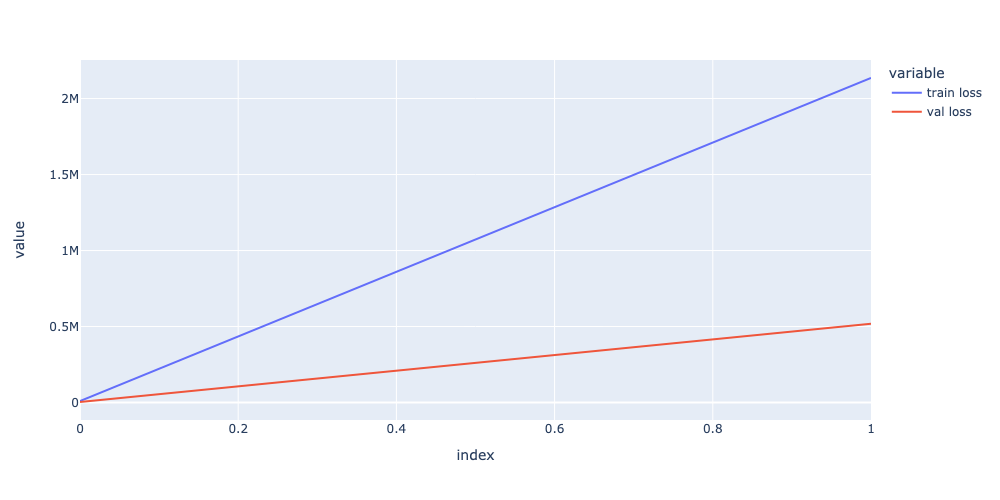

In [273]:
px.line(pd.DataFrame({'train loss': loss_log, 'val loss': loss_log_val})).show(renderer='png', width=1000)

In [148]:
right_answers = 0
review_answers = []
model.eval()

for batch_x, batch_y in tqdm(DataLoader(review_valid_ds, batch_size=128)):
    predictions = model(batch_x).argmax(dim=1)
    right_answers += (torch.eq(batch_y, predictions)).sum()
    review_answers.extend(predictions)

print(f'TEST ACCURACY: {right_answers / len(review_valid_ds):0.4f}')

100%|██████████| 25/25 [00:00<00:00, 31.97it/s]

TEST ACCURACY: 0.5123
